# Exercise 01

In this exercise we try to cover linear models, LIME and SHAP analysis.
We import our required libraries and set random seeds for reproducability.

## Dataset Preparation

First we fetch the [California Housing Dataset](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset) and take a first look at the data. The function returns two [pandas.DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) objects (think mix of Excel and NumPy Arrays)

In [1]:
import abc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import tqdm

from sklearn import datasets

features, labels = datasets.fetch_california_housing(return_X_y=True, as_frame=True)
features.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In many cases, it can already be helpful to perform a visual inspection of our dataset. This helps us identify first patterns, clusters, or malformed distributions, indicating the need for feature normalization.

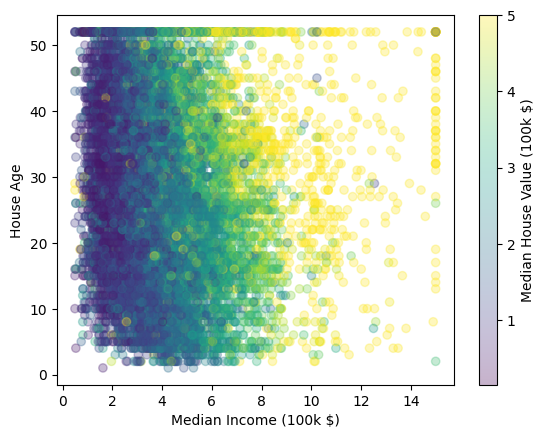

In [2]:
plt.scatter(features["MedInc"], features["HouseAge"], c=labels, alpha=0.3)
plt.xlabel("Median Income (100k $)")
plt.ylabel("House Age")
cbar = plt.colorbar()
cbar.ax.set_ylabel("Median House Value (100k $)")
plt.show()

We perform a train- and test-split of our dataset.

In [3]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.33, random_state=42
)
print(train_features.shape, test_labels.shape)

(13828, 8) (6812,)


# Linear Regression

We use PyTorch do define our own Linear Regression Model.
Our Implementation allows us to define our training objective afterwards, allowing different training regimes.

*Note that we have a bug somewhere, which is why the results are bad and the learning rate is stupid.*


In [81]:
class LinearRegressor(torch.nn.Module):
    def __init__(self, num_features: int, num_outputs: int) -> None:
        """Simple Linear Regressor in Torch.
        Args:
            num_features (int): number of feature dimensions
            num_outputs (int): number of output dimensions
        """

        torch.manual_seed(42)
        np.random.seed(42)

        super().__init__()
        self.linear = torch.nn.Linear(num_features, num_outputs)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Network forward function

        Args:
            x (torch.Tensor): Input Tensor (BATCH x FEATURES)

        Returns:
            torch.Tensor: model prediction (BATCH x OUTPUT)
        """
        out = self.linear(x)
        return out

    def weights(self) -> np.ndarray:
        """get regressor weights

        Returns:
            np.ndarray: model weights (FEATURES,)
        """
        return self.linear.weight.detach().numpy().squeeze()

    def predict(self, x: pd.DataFrame) -> np.ndarray:
        """make model prediction outside of torch

        Args:
            x (pd.DataFrame): input dataframe (BATCH x FEATURES)

        Returns:
            np.ndarray: model prediction (BATCH x OUTPUT)
        """
        tensor = torch.tensor(x.values, dtype=torch.float32)
        pred = self.forward(tensor)
        return pred.detach().numpy()


def optimize_lin_reg(model, loss_fn, epochs=2, tf=None):
    """Training Loop

    Args:
        model: torch model
        loss_fn: callable function as loss / optimization criterion
        epochs (int, optional): number of training epochs Defaults to 2.
        tf (pd.DataFrame, optional): Training Feature Set. If None, take global train_features. Defaults to None.

    Returns:
        tuple: trained model, array of loss values
    """

    if tf is None:
        tf = train_features
    # SGD is not the ideal choice - see ridiculous learning rate - No Time to do it right.
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.1)

    feature_tensor = torch.tensor(tf.values, dtype=torch.float32)[:]
    label_tensor = torch.tensor(train_labels.values, dtype=torch.float32)[:, None]
    losses = []

    for _ in tqdm.tqdm(range(epochs)):
        optimizer.zero_grad()
        preds = model.forward(feature_tensor)
        loss = loss_fn(label_tensor, preds, model.linear.weight)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] * 0.99
    return model, losses

# Task 01: Linear Regression Objectives
Linear Regression can be trained with different objective functions.

### 1.1 Ordinary Least Squares:
Complete the function stub for ordinary least squares objective as discussed in the lecture. *As this function is used by the torch optimizer, only use torch functions, no numpy.*




In [6]:
def ordinary_least_squares(
    true_y: torch.Tensor, pred_y: torch.Tensor, weights: torch.Tensor
) -> torch.Tensor:
    """ordinary least squares target / loss function

    Args:
        true_y (torch.Tensor): actual target values (BATCH x 1)
        pred_y (torch.Tensor): predicted values (BATCH x 1)
        weights (torch.Tensor): model weights (BATCH x FEATURES). Might not be required

    Returns:
        torch.Tensor: Loss Value (1,). Basically a float
    """

    res = torch.square(true_y - pred_y)

    return torch.mean(res)

### 1.2 Ridge Regression:
Complete the function stub for the ridge regression objective as discussed in the lecture. *As this function is used by the torch optimizer, only use torch functions, no numpy.*

In [94]:
def ridge(
    true_y: torch.Tensor, pred_y: torch.Tensor, weights: torch.Tensor
) -> torch.Tensor:
    """ridge regression target / loss function

    Args:
        true_y (torch.Tensor): actual target values (BATCH x 1)
        pred_y (torch.Tensor): predicted values (BATCH x 1)
        weights (torch.Tensor): model weights (BATCH x FEATURES). Might not be required

    Returns:
        torch.Tensor: Loss Value (1,). Basically a float
    """
    alpha = 5  # DO (NOT) CHANGE!!

    res = (true_y - pred_y) ** 2 + alpha * torch.sum((weights**2), axis=1)

    return torch.mean(res)

### 1.3 R2 Score
The R2 Score is a metric to estimate model fit to the data. Complete the function stub for the r2 score function.
For simplicities sake, use **only** numpy functions, no torch!! (Sorry)

In [8]:
def r2_score(pred: np.ndarray, target: np.ndarray) -> float:
    """R2 metric function

    Args:
        pred (np.ndarray): Numpy array of predictions (BATCH x 1)
        target (np.ndarray): Numpy array of target values (BATCH x 1)

    Returns:
        float: r2 score
    """

    sse = np.sum(np.square(pred - target))
    sst = np.sum(np.square(pred - np.mean(target)))
    return 1.0 - sse / sst

## Model Evaluation
We define some helpful functions for model evaluation.

In [9]:
from sklearn.metrics import mean_squared_error


def eval(model, loss: list, tf=None):
    """create some evaluation plots

    Args:
        model: regression model
        loss (list): list of loss values
        tf (pd.DataFrame, optional): Test Feature Set. If None, take global test_features. Defaults to None.
    """
    if tf is None:
        tf = test_features

    fig, axs = plt.subplots(1, 2)

    # Loss Curve
    axs[0].plot(np.log(loss))
    axs[0].set_ylabel("Log-Loss")

    # Weight Plot
    axs[1].bar(tf.columns, model.weights())
    axs[1].tick_params(axis="x", labelrotation=45)

    # MSE and R2 Score
    pred = model.predict(tf)
    mse = mean_squared_error(test_labels, pred)
    r2 = r2_score(pred.squeeze(), test_labels)
    fig.suptitle(f"MSE: {mse:.3f} R2: {r2:.3f}")

    plt.show()

First we train a normal Linear Regression Model.

100%|██████████| 200/200 [00:00<00:00, 737.32it/s]


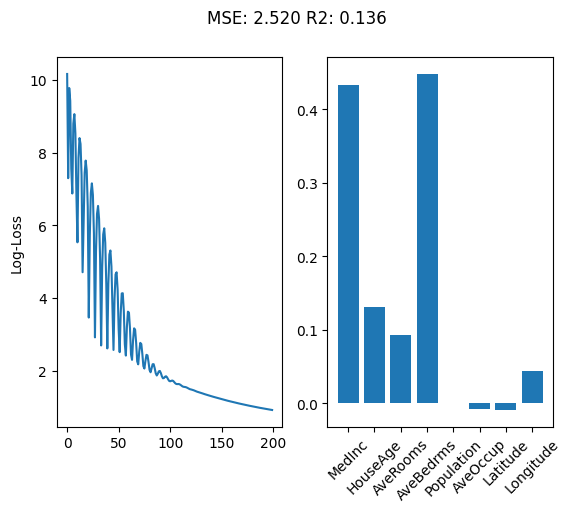

In [83]:
lr = LinearRegressor(train_features.shape[1], 1)
lr, loss = optimize_lin_reg(lr, ordinary_least_squares, epochs=200)

eval(lr, loss)

We can see the influence of the model, when we use the ridge regression target function:

Note the values on the weight's y-axis. The regularizer is so dominating, that the weights are all basically zero.
This is intentional to give the greatest visual change in the plot compared to the one above.

100%|██████████| 200/200 [00:00<00:00, 1116.06it/s]


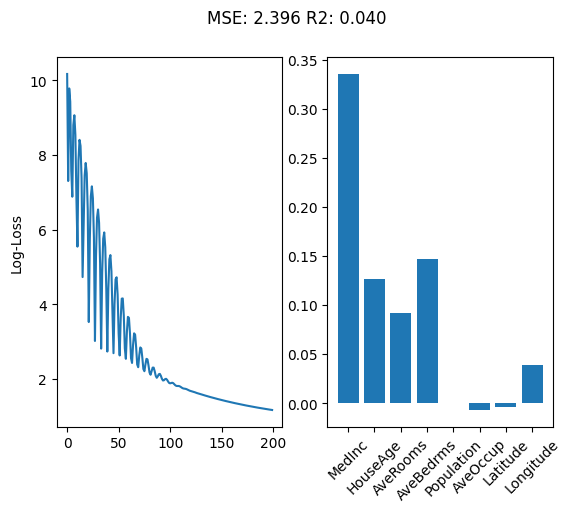

In [95]:
ridge_lr = LinearRegressor(train_features.shape[1], 1)
ridge_lr, loss = optimize_lin_reg(ridge_lr, ridge, epochs=200)

eval(ridge_lr, loss)

## Question: How would you rate both Model's overall Performance?

# Additional Info: Regularization

We now construct an example to show the advantage of regularization. First, we create a corrupted training set, where the label is part of the features. This should lead to a model which focuses only on one feature.

As our own pytorch LR model is buggy, we will use the scikit-learn models to demonstrate the purpose of regularization.

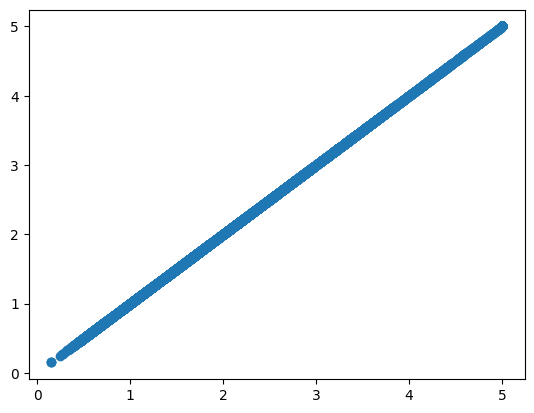

In [96]:
corrupted_train_features = pd.concat([train_features, train_labels], axis=1)
plt.scatter(corrupted_train_features.iloc[:, -1], train_labels)
plt.show()

The unregularized regression model overfits on the corrupting feature:

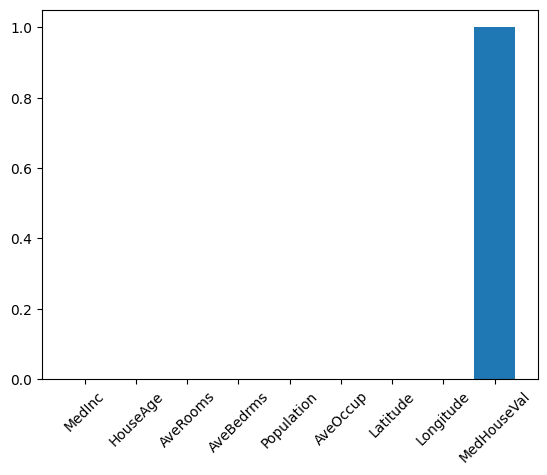

In [98]:
from sklearn import linear_model

lr = linear_model.LinearRegression()
lr.fit(corrupted_train_features, train_labels)

plt.bar(corrupted_train_features.columns, lr.coef_)
plt.xticks(rotation=45)
plt.show()

By using Ridge regression, this behaviour is punished. The other features wil also be considered:

(Even though because of the perfect fit, we have to use a very high alpha value.)

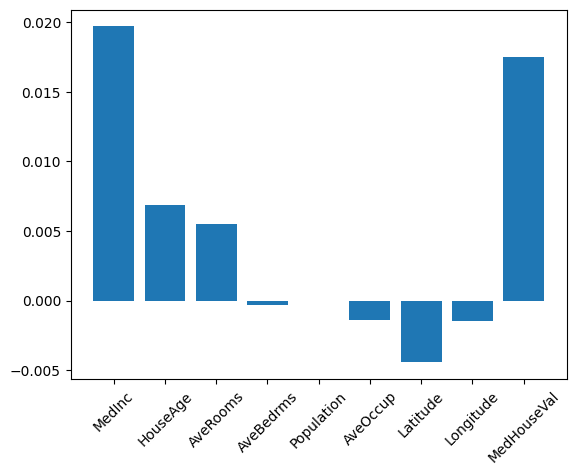

In [101]:
lr = linear_model.Ridge(alpha=1000000)
lr.fit(corrupted_train_features, train_labels)

plt.bar(corrupted_train_features.columns, lr.coef_)
plt.xticks(rotation=45)
plt.show()

# Task 02: LIME

LIME is a posthoc analyis method for explaining complex models. To showcase lime, we first define our "deep" neural network and train it on our dataset.

100%|██████████| 10/10 [00:00<00:00, 38.90it/s]


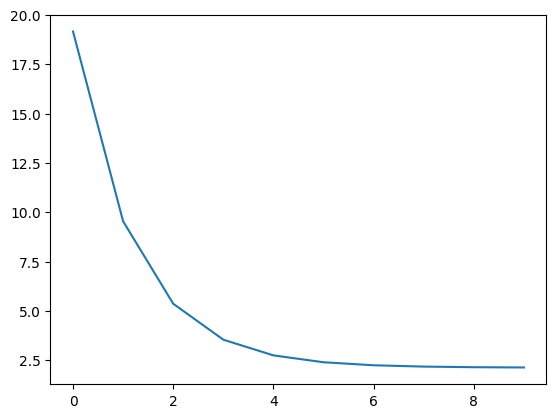

In [107]:
import torch


class ComplexNetwork(torch.nn.Module):
    """A more Complex neural network with hidden layers."""

    def __init__(self, num_features, num_outputs):
        super().__init__()
        torch.manual_seed(42)
        np.random.seed(42)
        self.net = torch.nn.Sequential(
            torch.nn.Linear(num_features, num_features * 4),
            torch.nn.ReLU(),
            torch.nn.Linear(num_features * 4, num_features * 4),
            torch.nn.ReLU(),
            torch.nn.Linear(num_features * 4, num_features * 4),
            torch.nn.ReLU(),
            torch.nn.Linear(num_features * 4, num_outputs),
        )

    def forward(self, x):
        return self.net(x)

    def predict(self, x_array: np.ndarray) -> np.ndarray:
        """make model prediction outside of torch

        Args:
            x_array (np.ndarray): input array (BATCH x FEATURES)

        Returns:
            np.ndarray: model prediction (BATCH x OUTPUT)
        """
        x_tensor = torch.tensor(x_array, dtype=torch.float32)
        return self.forward(x_tensor).detach().numpy()


def train_net(model, epochs=5, tf=None):
    """Training Loop

    Args:
        model: torch model
        epochs (int, optional): number of training epochs Defaults to 2.
        tf (pd.DataFrame, optional): Training Feature Set. If None, take global train_features. Defaults to None.

    Returns:
        tuple: trained model, array of loss values
    """

    if tf is None:
        tf = train_features
    # SGD is not the ideal choice - see ridiculous learning rate - No Time to do it right.
    optimizer = torch.optim.SGD(model.parameters(), lr=0.000001)

    feature_tensor = torch.tensor(tf.values, dtype=torch.float32)[:]
    label_tensor = torch.tensor(train_labels.values, dtype=torch.float32)[:, None]
    losses = []

    for _ in tqdm.tqdm(range(epochs)):
        optimizer.zero_grad()
        preds = model.forward(feature_tensor)
        loss = torch.nn.functional.mse_loss(preds, label_tensor)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    return model, losses


cn = ComplexNetwork(train_features.shape[1], 1)
cn, loss = train_net(cn, 10)
plt.plot(loss)
plt.show()

### 2.1 Data Pertubation

We now need a function to get samples from the local neighborhood of our sample of interest.
Write a function, which takes an array of identical copies of a point of interest (poi) and the standard deviation of all features, to return an array with perturbed data points.

In [104]:
poi = test_features.iloc[50].values[None, :]
pois = np.repeat(poi, 100, axis=0)
print("POIs SHAPE", pois.shape)

std = train_features.std()
std

POIs SHAPE (100, 8)


,0
MedInc,1.903102
HouseAge,12.600767
AveRooms,2.449446
AveBedrms,0.445688
Population,1146.236335
AveOccup,12.646130
Latitude,2.134064
Longitude,2.005127


In [108]:
def perturb(pois: np.ndarray, std: np.ndarray):
    """Perturbs an array of pois

    Args:
        pois (np.ndarray): points of interest (BATCH x FEATURES)
        std (np.ndarray): array of std values (1 x FEATURES)

    Returns:
        _type_: _description_
    """
    noise = np.random.randn(*pois.shape)

    new_pois = pois + noise * 0.05 * std
    return new_pois


perturbed_features = perturb(pois, std.values[None, :])
perturbed_labels = cn.predict(perturbed_features).squeeze()
print("MEAN PERTUBATION PER FEATURE: ", np.mean(perturbed_features, axis=0) - poi)

MEAN PERTUBATION PER FEATURE:  [[-6.65206498e-03  1.02355595e-01  1.52541791e-02  1.61357620e-03
  -3.31419347e+00 -1.10447358e-01 -1.12734151e-02 -1.45784306e-03]]


## 2.2 Surrogate Model
Now we need to train an interpretable surrogate model on our perturbed dataset `(perturbed_features, perturbed_labels)`. The sections above should hold all the information you need to be able get to an explanation. We recommend you use scikit-learn models and not our own pytorch implementation.

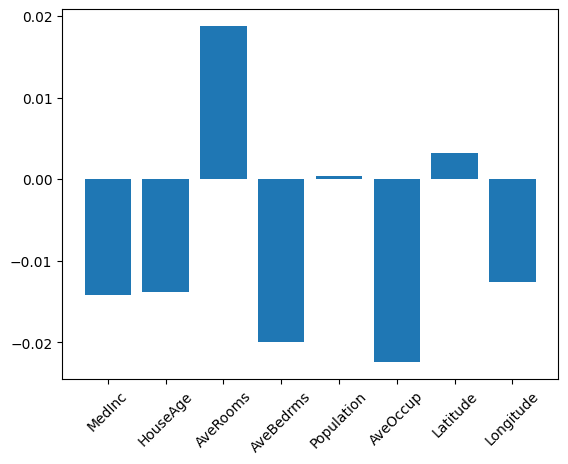

In [109]:
lr = linear_model.LinearRegression()
lr.fit(perturbed_features, perturbed_labels)

plt.bar(train_features.columns, lr.coef_)
plt.xticks(rotation=45)
plt.show()

# SHAP Examples

SHAP and shapley values are some of the most widely used explanation methods at the moment. We now explore some visualization examples provided by the python library `shap`.

In [ ]:
!pip install shap -q

The [Beeswarm](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/beeswarm.html) plot is very information dense. Each dot represents a sample, with the SHAP value (impact) on the X axis, the feature value encoded by color and the piling up along y signifying density.

This is a global model explanation.

ExactExplainer explainer: 201it [00:17,  6.26it/s]                         


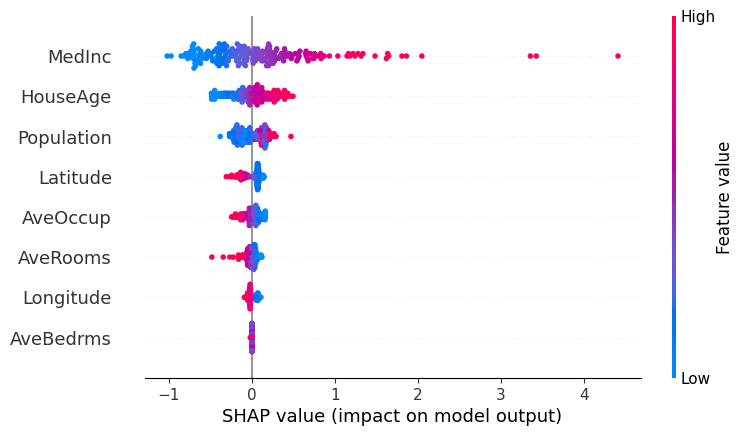

In [ ]:
import shap
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(hidden_layer_sizes=[32, 100, 32])
model.fit(train_features, train_labels)

explainer = shap.Explainer(model.predict, train_features.iloc[:200])
shap_values = explainer(train_features.iloc[:200])

shap.plots.beeswarm(shap_values)

The [Heatmap Visualization](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/heatmap.html) sorts the outputs by the model value (line at the top, left to right) and shows the impact of each sample instance. The color is now the SHAP value, not the feature value!

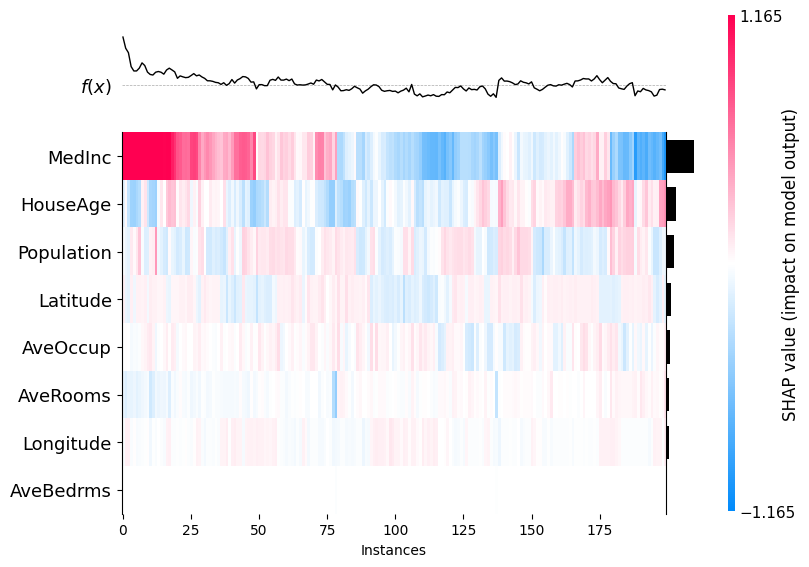

<Axes: xlabel='Instances'>

In [ ]:
shap.plots.heatmap(shap_values)

The SHAP Waterfall plot is designed for explaining the "decision" process for a single example. It is a local explanation method.

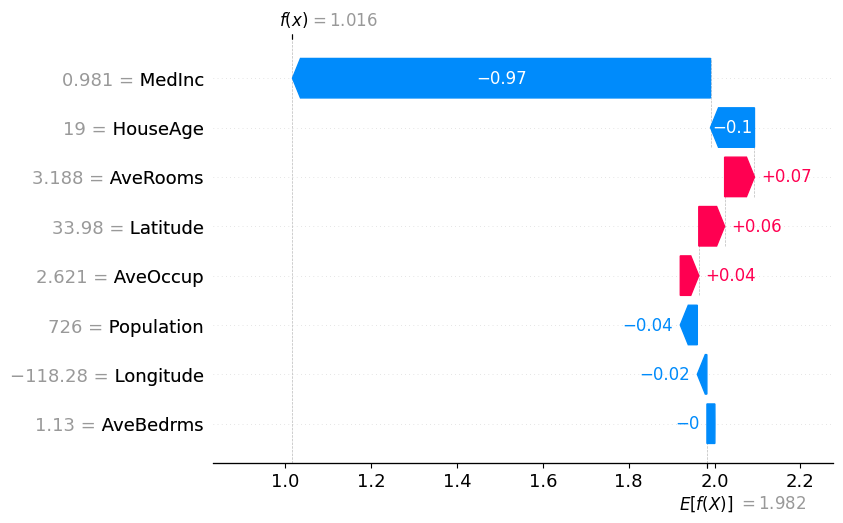

In [ ]:
shap.plots.waterfall(shap_values[0])